### Parameters

In [1]:
Ω = 2.5

h_cut = 1

In [2]:
import numpy as np

num_layers = 2
num_periods = 1
num_time_steps = 100
T = num_periods * 2*np.pi/Ω
dt = T / num_time_steps

In [3]:
from qiskit.circuit import ParameterVector, Parameter

cost_threshold = 1e-3

### Functions

#### QFT and QFT$^\dagger$

In [4]:
#QFT Circuit
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

#Inverse Quantum Fourier Transform
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    return qc

#### Ansatz creator for spin chain

In [5]:
def create_ansatz_circuit(qc, num_layers, param_space):
    param_counter = -1
    def ansatz_circuit_0(qc, param_space, param_counter=0):
        print('Number of params:',parameter_space_size)
        # layer 0
        # param_counter=0
        for i in range(qc.num_qubits):
            qc.rx(param_space[param_counter:=param_counter+1],i)
            qc.rz(param_space[param_counter:=param_counter+1],i)
        return param_counter
    def ansatz_circuit_1(qc, param_space, param_counter=0):
        # param_counter = 2 * chain_length
        for i in range(qc.num_qubits-1):
            qc.cx(i,i+1)
        qc.cx(-1,0)
        for i in range(qc.num_qubits):
            qc.rz(param_space[param_counter:=param_counter+1],i)
            qc.rx(param_space[param_counter:=param_counter+1],i)
            qc.rz(param_space[param_counter:=param_counter+1],i)
        return param_counter
    param_counter = ansatz_circuit_0(qc, param_space, param_counter)
    for i in range(num_layers):
        param_counter = ansatz_circuit_1(qc, param_space, param_counter)
    # display(qc.draw('mpl'))

#### Ansatz creator for spin ladder

In [6]:
def ansatz_circuit_ladder(qc, param_space, num_layers, omit_ratio):
    counter = -1
    def layer(qc, params, param_counter):
        for i in range(qc.num_qubits):
            qc.rx(params[param_counter:=param_counter+1],i)
            qc.rz(params[param_counter:=param_counter+1],i)
        return param_counter
    def entangle(qc, params, param_counter, double_entangle):
        for i in range(qc.num_qubits//2):
            qc.rzz(params[param_counter:=param_counter+1], 2*i, 2*i+1)
        if double_entangle:
            for i in range((qc.num_qubits-1)//2):
                qc.rzz(params[param_counter:=param_counter+1], 2*i+1, 2*i+2)
        return param_counter
    fra = Fraction(omit_ratio).limit_denominator()
    # print(fra)
    for layer_count in range(num_layers):
        counter = layer(qc, param_space, counter)
        counter = entangle(qc, param_space, counter, double_entangle=(layer_count%fra.denominator<fra.numerator))
        qc.barrier()
    display(qc.draw('mpl'))

#### Hamiltonians

In [7]:
def hamiltonian_circular(t, A=2, J=1, omega=Ω):
    creator = ['I']*chain_length
    paulis = ['I','X','Y','Z']
    ham = [] # [('X',1.0)]
    for i in range(chain_length-1):
        for j in range(1,4):
            op = creator[:]
            op[i] = paulis[j]
            op[i+1] = paulis[j]
            ham.append([''.join(op), -J/4])
    for i in range(chain_length):
        op1, op2 = creator[:], creator[:]
        op1[i] = 'X'
        op2[i] = 'Y'
        ham.append([''.join(op1), A * np.cos(omega*t)])
        ham.append([''.join(op2), A * np.sin(omega*t)])
    ham = np.array(ham)
    # print(A * np.cos(Ω*t))
    return SparsePauliOp(ham[:,0], ham[:,1])

def hamiltonian_linear(t, A, Δ=1, omega=Ω):
    ham = SparsePauliOp(['Z','X'] , [-Δ/2, A/2*np.cos(omega*t)])
    # plt.plot(t, A*np.cos(Ω*t)/2,'.')
    return ham

def hamiltonian():
    pass

#### Unitary time evolution

In [8]:
def unitary_time_evolver(ham, *args, num_qbits, time=T, dt=dt):#num_steps=num_time_steps):

    circuit = QuantumCircuit(num_qbits)
    
    for i in range(1, int(time/dt)+1):
        circuit.compose(HamiltonianGate(ham(i*dt, *args), time=dt), inplace=True)
        # print(Operator(HamiltonianGate(ham(i*dt, *args), time=dt)).is_unitary())
    
    return circuit

### From qiskit docs

First, we'll setup a function that calculates the state fidelity -- a percentage of overlap between two states that we'll use as a penalty for VQD:

wtf is this

In [9]:
import numpy as np

def calculate_overlaps(ansatz, prev_circuits, parameters, estimator):

    def create_fidelity_circuit(circuit_1, circuit_2):

        """
        Constructs the list of fidelity circuits to be evaluated.
        These circuits represent the state overlap between pairs of input circuits,
        and their construction depends on the fidelity method implementations.
        """
                
        if len(circuit_1.clbits) > 0:
            circuit_1.remove_final_measurements()
        if len(circuit_2.clbits) > 0:
            circuit_2.remove_final_measurements()

        circuit = circuit_1.compose(circuit_2.inverse())
        # circuit.measure_all()
        return circuit
    overlaps = []

    matrix = np.zeros((2**ansatz.num_qubits,2**ansatz.num_qubits))
    matrix[0,0] = 1
    observable = SparsePauliOp.from_operator(matrix)

    for prev_circuit in prev_circuits:
        fidelity_circuit = create_fidelity_circuit(ansatz, prev_circuit)
        estimator_job = estimator.run([(fidelity_circuit, observable, [parameters])])
        estimator_result = estimator_job.result()[0]
        value = estimator_result.data.evs[0]
        
        overlaps.append(value)
    
    return np.array(overlaps)

It's time to write VQD's cost function:

#### Cost function

In [10]:
import numpy as np

def cost_func_vqd(parameters, U_T, ansatz, prev_states, step, betas, estimator, hamiltonian, sign=-1):

    '''
    Estimates <ψ|H|ψ> - λ Σ |<0|(U_θβ†)(U_θ)|0>|²

    Where:
    H = observable
    |ψ> = (U_θ†)(U_T)(U_θ)|0>
    '''

    circuit = ansatz.compose(U_T)
    circuit.compose(ansatz.inverse(),inplace=True)
    estimator_job = estimator.run([(circuit, hamiltonian, [parameters])])

    total_cost = 0

    if step > 1:
        overlaps = calculate_overlaps(ansatz, prev_states, parameters, estimator)
        total_cost = np.sum([np.real(betas[state] * overlap**2) for state, overlap in enumerate(overlaps)])

    estimator_result = estimator_job.result()[0]

    value = estimator_result.data.evs[0] - total_cost

    return value*sign

### Linear Driver code (suppressed)

In [11]:
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.primitives import StatevectorEstimator as Estimator
estimator = Estimator()

In [12]:
# from qiskit.quantum_info import SparsePauliOp, Statevector, Operator, Pauli
# from qiskit import QuantumCircuit
# from qiskit.circuit.library import HamiltonianGate, UGate
# from scipy.optimize import minimize
# from optimparallel import minimize_parallel
# import time

# # j = 1

# k = 2**1
# betas = [5]*k
# x0 = np.random.uniform(-np.pi, np.pi, size=3)

# A_Array = np.linspace(0,4,8)

# def evolver_gen():
#     for A in A_Array:
#         yield unitary_time_evolver(hamiltonian_linear, A*Ω, num_qbits=1)

# matrix = np.array([[1,0],[0,0]])
# observable = SparsePauliOp.from_operator(matrix)
# ground_states = []
# excited_states = [] 
# costs = []

# t0p = time.perf_counter()
# for U_T in evolver_gen():

#     ansatz = QuantumCircuit(1)
#     theta = ParameterVector('θ',3)
#     ansatz.u(*theta,0)
    
    
#     prev_states = []
#     prev_opt_parameters = []
#     eigenvalues = []


# # try:
#     for step in range(1, k + 1):
        
#         result = minimize_parallel(cost_func_vqd, x0, args=(U_T, ansatz, prev_states, step, betas, estimator, observable))#, method="bfgs")
        
#         prev_opt_parameters = result.x
        
#         ### Computes expectation value of optimised circuit

#         floquet_mode = Statevector.from_instruction(ansatz.assign_parameters(prev_opt_parameters))
        
#         eigenvalues.append(-np.angle(floquet_mode.expectation_value(U_T))/T)
        
#         prev_states.append(ansatz.assign_parameters(prev_opt_parameters))

#         costs.append(-result.fun)
    
#     eigenvalues = np.array(eigenvalues)/Ω
#     eigenvalues.sort()
#     # print(eigenvalues.shape)
#     ground_states.append(eigenvalues[0])
#     excited_states.append(eigenvalues[1])

# # except Exception as e:
# #     print(e)
# costs = np.array(costs).reshape(8,2)

# t1p = time.perf_counter()

In [13]:
# from qiskit.quantum_info import SparsePauliOp, Statevector, Operator, Pauli
# from qiskit import QuantumCircuit
# from qiskit.circuit.library import HamiltonianGate, UGate
# from scipy.optimize import minimize
# from optimparallel import minimize_parallel
# import time

# # j = 1

# k = 2**1
# betas = [5]*k
# x0 = np.random.uniform(-np.pi, np.pi, size=3)

# A_Array = np.linspace(0,4,8)

# def evolver_gen():
#     for A in A_Array:
#         yield unitary_time_evolver(hamiltonian_linear, A*Ω, num_qbits=1)

# matrix = np.array([[1,0],[0,0]])
# observable = SparsePauliOp.from_operator(matrix)
# ground_states = []
# excited_states = [] 
# costs = []

# t0s = time.perf_counter()
# for U_T in evolver_gen():

#     ansatz = QuantumCircuit(1)
#     theta = ParameterVector('θ',3)
#     ansatz.u(*theta,0)
    
    
#     prev_states = []
#     prev_opt_parameters = []
#     eigenvalues = []


# # try:
#     for step in range(1, k + 1):
        
#         result = minimize(cost_func_vqd, x0, args=(U_T, ansatz, prev_states, step, betas, estimator, observable), method="l-bfgs-b")
        
#         prev_opt_parameters = result.x
        
#         ### Computes expectation value of optimised circuit

#         floquet_mode = Statevector.from_instruction(ansatz.assign_parameters(prev_opt_parameters))
        
#         eigenvalues.append(-np.angle(floquet_mode.expectation_value(U_T))/T)
        
#         prev_states.append(ansatz.assign_parameters(prev_opt_parameters))

#         costs.append(-result.fun)
    
#     eigenvalues = np.array(eigenvalues)/Ω
#     eigenvalues.sort()
#     # print(eigenvalues.shape)
#     ground_states.append(eigenvalues[0])
#     excited_states.append(eigenvalues[1])

# # except Exception as e:
# #     print(e)
# costs = np.array(costs).reshape(8,2)

# t1s = time.perf_counter()

In [14]:
# # print(eigenvalues)

# print('time taken serial: %.2f s'%(t1s-t0s))
# ground_states=np.array(ground_states)
# excited_states=np.array(excited_states)
# print('time taken parallel: %.2f s'%(t1p-t0p))
# # print(excited_states[0])

time taken serial: 20.67 s

time taken parallel: 13.71 s

#### Plotter

In [15]:
# import matplotlib.pyplot as plt
# import os
# num = 1
# while os.path.isfile(f'.//outputs//figure{num}.png'):
#     num += 1

# plt.plot(A_Array, ground_states.real,'b.')
# plt.plot(A_Array, excited_states.real,'r.')
# plt.grid()
# plt.xlabel('$A/\\Omega$')
# plt.ylabel('$\\epsilon/\\Omega$')
# plt.title('Initial guess: {}'.format(x0))
# # plt.savefig(f'.//outputs//figure{num}.png')

#### Plotting the cost function

In [16]:
# plt.plot(A_Array, costs[:,0],'x',label='ground states')
# plt.plot(A_Array, costs[:,1],'.',label='excited states')
# plt.legend()
# plt.ylim(0,1.3)
# plt.ylabel('$\\mathcal{L}(\\theta)$')
# plt.xlabel('$A/\\Omega$')
# plt.grid()
# num = 1
# while os.path.isfile(f'.//outputs//figure{num}.png'):
#     num += 1
# # plt.savefig(f'.//outputs//figure{num}.png')

### Circular Driving

#### Convergence function

In [17]:
def convergence_parameter(ansatz, parameters, U_T):
    circuit = ansatz.assign_parameters(parameters)
    floquet_mode = Statevector.from_instruction(circuit)
    value = floquet_mode.expectation_value(U_T)
    return (1 - np.abs(value))**2

#### Driver code

In [18]:
# from qiskit.quantum_info import SparsePauliOp, Statevector, Operator, Pauli
# from qiskit import QuantumCircuit
# from qiskit.circuit.library import HamiltonianGate, UGate
# from scipy.optimize import minimize
# from optimparallel import minimize_parallel
# import time

# # j = 1

# chain_length = 4

# U_T = unitary_time_evolver(hamiltonian_circular)

# matrix = np.zeros((2**chain_length, 2**chain_length))
# matrix[0,0] = 1
# observable = SparsePauliOp.from_operator(matrix)
# ground_states = []
# excited_states = [] 
# costs = []

# layers = range(1,4)

# t0 = time.perf_counter()
# for num_layers in layers:

#     parameter_space_size = 2 * chain_length + 3 * chain_length * num_layers
#     param_space = ParameterVector('θ', parameter_space_size)

#     k = 2**chain_length
#     betas = [5]*k
#     x0 = np.random.uniform(-np.pi, np.pi, size=parameter_space_size)
    
    

#     ansatz = QuantumCircuit(chain_length)
#     create_ansatz_circuit(ansatz, num_layers, param_space)
    
    
    
#     prev_states = []
#     prev_opt_parameters = []
#     eigenvalues = []
#     ϵ2 = 0


# # try:
#     for step in range(1, k + 1):
        
#         result = minimize(cost_func_vqd, x0, args=(U_T, ansatz, prev_states, step, betas, estimator, observable), method="bfgs")
        
        
#         prev_opt_parameters = result.x
        

#         # floquet_mode = Statevector.from_instruction(ansatz.assign_parameters(prev_opt_parameters))
        
#         # eigenvalues.append(-np.angle(floquet_mode.expectation_value(U_T))/T)
        
#         # prev_states.append(ansatz.assign_parameters(prev_opt_parameters))

#         # costs.append(-result.fun)
#         ϵ2 += convergence_parameter(ansatz, prev_opt_parameters, U_T)
    
#     costs.append(ϵ2**.5)

# # except Exception as e:
# #     print(e)
# # costs = np.array(costs).reshape(8,2)

# t1 = time.perf_counter()

#### Plotter

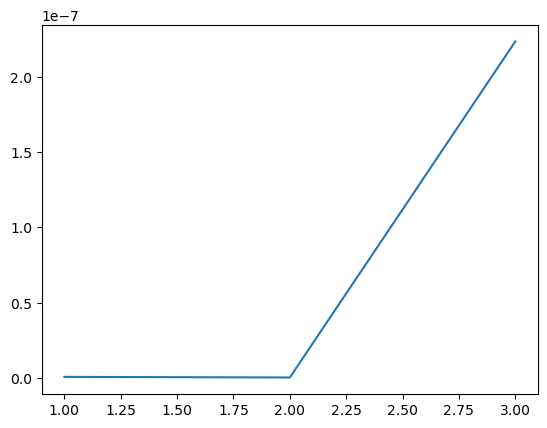

In [19]:
import numpy as np
import matplotlib.pyplot as plt

filepath = './outputs/data.npz'

with open(filepath,'rb') as file:
    data = np.load(file)

    layers = data['layers']
    costs = data['costs']

plt.plot(layers,costs)
# plt.xlim(2,3)
plt.show()

### My work

In [20]:
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator, Pauli
from qiskit import QuantumCircuit
from qiskit.circuit.library import HamiltonianGate, UGate
from scipy.optimize import minimize
from optimparallel import minimize_parallel
import time
from fractions import Fraction

# j = 1

chain_length = 4
omit_ratio = 0

U_T = unitary_time_evolver(hamiltonian_circular, num_qbits=chain_length)

matrix = np.zeros((2**chain_length, 2**chain_length))
matrix[0,0] = 1
observable = SparsePauliOp.from_operator(matrix)
ground_states = []
excited_states = [] 
costs = []

layers = range(7,8)

t0 = time.perf_counter()
for num_layers in layers:

    parameter_space_size2 = 2 * chain_length * num_layers + (omit_ratio*chain_length)//2 + (((chain_length*(1-omit_ratio)))//2-1)
    # print(parameter_space_size2)
    param_space2 = ParameterVector('θ', parameter_space_size2)

    k = 2**chain_length
    betas = [5]*k
    x0 = np.zeros(parameter_space_size2)
    
    

    ansatz = QuantumCircuit(chain_length)
    ansatz_circuit_ladder(ansatz, param_space2, num_layers, omit_ratio)
    
    
    
    prev_states = []
    prev_opt_parameters = []
    eigenvalues = []
    ϵ2 = 0


# try:
    for step in range(1, k + 1):
        
        result = minimize(cost_func_vqd, x0, args=(U_T, ansatz, prev_states, step, betas, estimator, observable), method="bfgs")
        
        
        prev_opt_parameters = result.x
        

        # floquet_mode = Statevector.from_instruction(ansatz.assign_parameters(prev_opt_parameters))
        
        # eigenvalues.append(-np.angle(floquet_mode.expectation_value(U_T))/T)
        
        # prev_states.append(ansatz.assign_parameters(prev_opt_parameters))

        # costs.append(-result.fun)
        ϵ2 += convergence_parameter(ansatz, prev_opt_parameters, U_T)
    
    costs.append(ϵ2**.5)

# except Exception as e:
#     print(e)
# costs = np.array(costs).reshape(8,2)

t1 = time.perf_counter()

IndexError: list index out of range

In [ ]:
# %timeit
# ansatz = QuantumCircuit(chain_length)
# ansatz_circuit_ladder(ansatz, param_space2, num_layers, omit_ratio)